# **Projecte 2 - Classificació**

> Llibreta final per a l'entrega del Projecte 2. Inclou: separació train/validació, EDA bàsica, pipeline de transformació de les dades, model de classificació i avaluació.  
> **Participants**: Alexander Ramirez Torres i Adrià Junquera Selma  
> **Nom del grup**: Adrià & Alex  

In [1]:
# some imports
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
sns.set_theme(style="darkgrid", context="talk", palette="mako")

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore")

# create output folder
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session1'):
    os.makedirs('output/session1')

# Machine learning imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, average_precision_score,
    precision_recall_curve, roc_curve, 
)

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.metrics import make_scorer
from tempfile import mkdtemp

# Extra y de pruebas: solo sirve para el modelo lineal parece:
from sklearn.feature_selection import RFECV

## 1. Obtenció de les dades

In [2]:
# try:
#     train_df = pd.read_csv('./train.csv', index_col=0)
#     test_df = pd.read_csv('./test_features.csv', index_col=0)

# except FileNotFoundError:
#     print("Error: Asegúrate de que las rutas de los archivos son correctas en tu entorno Kaggle.")

try:
    train_df = pd.read_csv('/kaggle/input/ml-ub-2025-project-2/train.csv', index_col=0)
    test_df = pd.read_csv('/kaggle/input/ml-ub-2025-project-2/test_features.csv', index_col=0)

except FileNotFoundError:
    print("Error: Asegúrate de que las rutas de los archivos son correctas en tu entorno Kaggle.")

### 1.2 Divisió de les dades - Train/Validation/Test

In [3]:
X = train_df.drop(columns=["loan_status"])
y = train_df["loan_status"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# NOTE: faltaría normalizar?

In [4]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    
    Y, X = np.meshgrid(y, x)
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
                levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=300, linewidth=1, facecolors='none',edgecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    y_pred = model.predict(xy).reshape(X.shape)
    y_decision = model.decision_function(xy).reshape(X.shape)
    ax.contourf(X, Y, y_pred, cmap=plt.cm.brg, alpha=0.2)
    ax.contourf(X, Y, y_decision, cmap=plt.cm.brg, alpha=0.1)

### 1.3 Exploració i anàlisi de les dades (EDA)

In [5]:
# Detecció de nuls, tipus, estadístics y distribucions simples
train_df.info()
# X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43983 entries, 0 to 43982
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  43983 non-null  int64  
 1   person_income               43983 non-null  int64  
 2   person_home_ownership       43983 non-null  object 
 3   person_emp_length           43983 non-null  float64
 4   loan_intent                 43983 non-null  object 
 5   loan_grade                  43983 non-null  object 
 6   loan_amnt                   43983 non-null  int64  
 7   loan_int_rate               43983 non-null  float64
 8   loan_percent_income         43983 non-null  float64
 9   cb_person_default_on_file   43983 non-null  object 
 10  cb_person_cred_hist_length  43983 non-null  int64  
 11  loan_status                 43983 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 4.4+ MB


In [6]:
train_df.isnull().sum()
# X_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Sembla que no hi ha dades nules...

In [7]:
X_train.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
40341,24,110000,MORTGAGE,8.0,DEBTCONSOLIDATION,B,8000,11.49,0.07,N,3
21572,33,48000,RENT,5.0,MEDICAL,B,10000,11.11,0.21,N,5
42587,22,72000,RENT,6.0,PERSONAL,C,12000,13.49,0.17,Y,4
19510,21,45000,RENT,5.0,EDUCATION,C,8000,12.84,0.18,N,10
16244,22,30000,RENT,6.0,MEDICAL,A,9500,6.62,0.32,N,2
39077,23,41004,MORTGAGE,7.0,DEBTCONSOLIDATION,A,10000,7.49,0.24,N,3
16317,25,31200,RENT,9.0,MEDICAL,B,6000,11.49,0.19,N,3
17082,21,70000,RENT,4.0,EDUCATION,A,6000,7.49,0.09,N,2
21315,29,44000,MORTGAGE,2.0,HOMEIMPROVEMENT,B,7000,12.42,0.16,N,10


In [8]:
# --- Definició de les columnes numèriques i categòriques ---
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

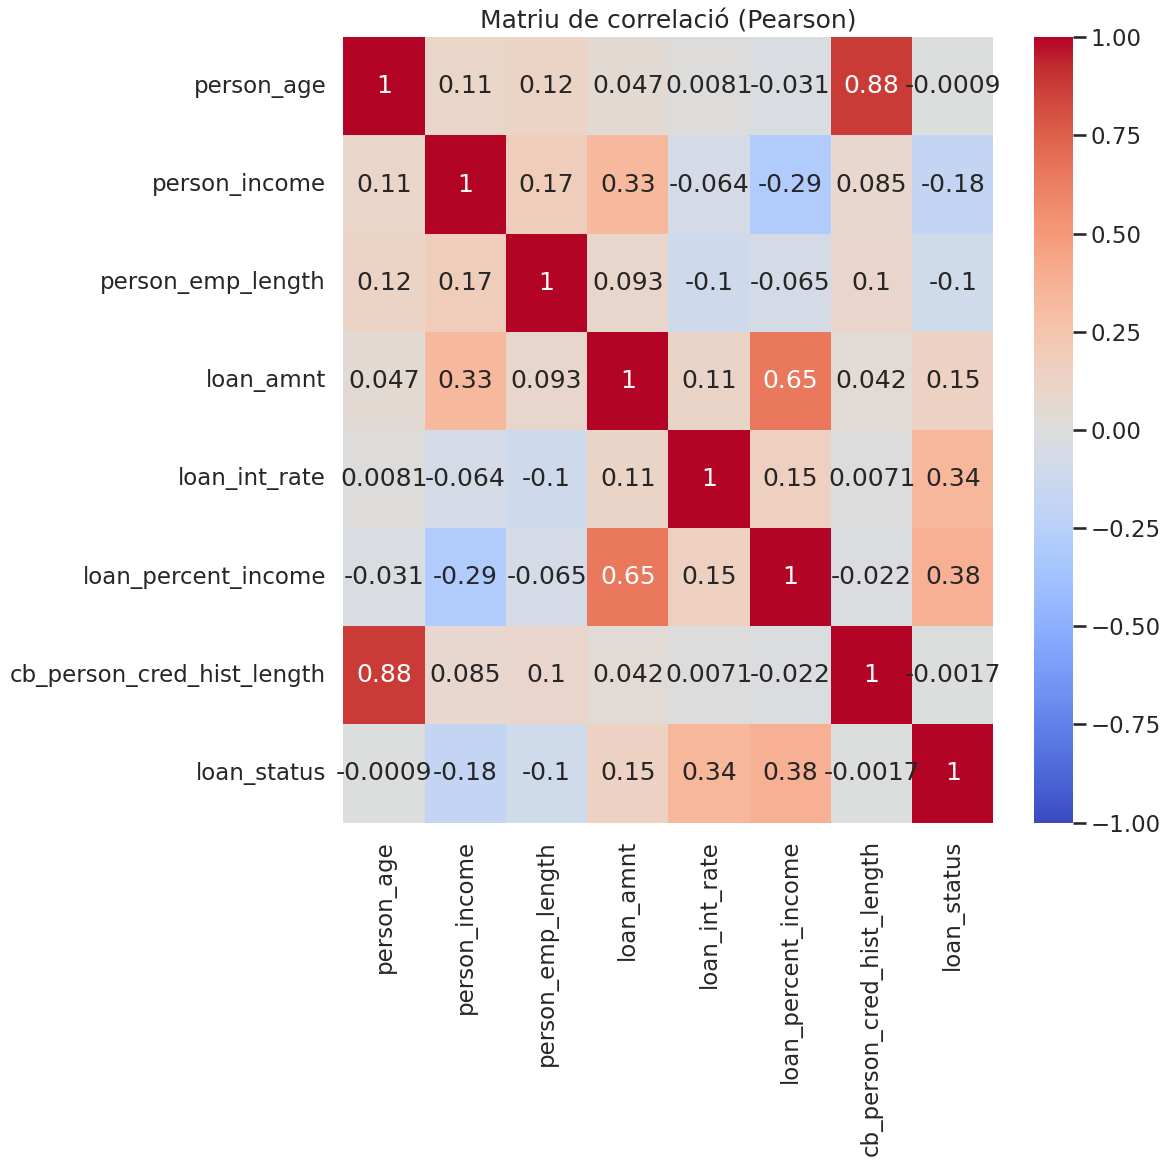

In [9]:
corr = train_df.select_dtypes(include=[np.number]).corr(method='pearson')

plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True, center=0)
plt.title("Matriu de correlació (Pearson)")
plt.tight_layout()
plt.show()

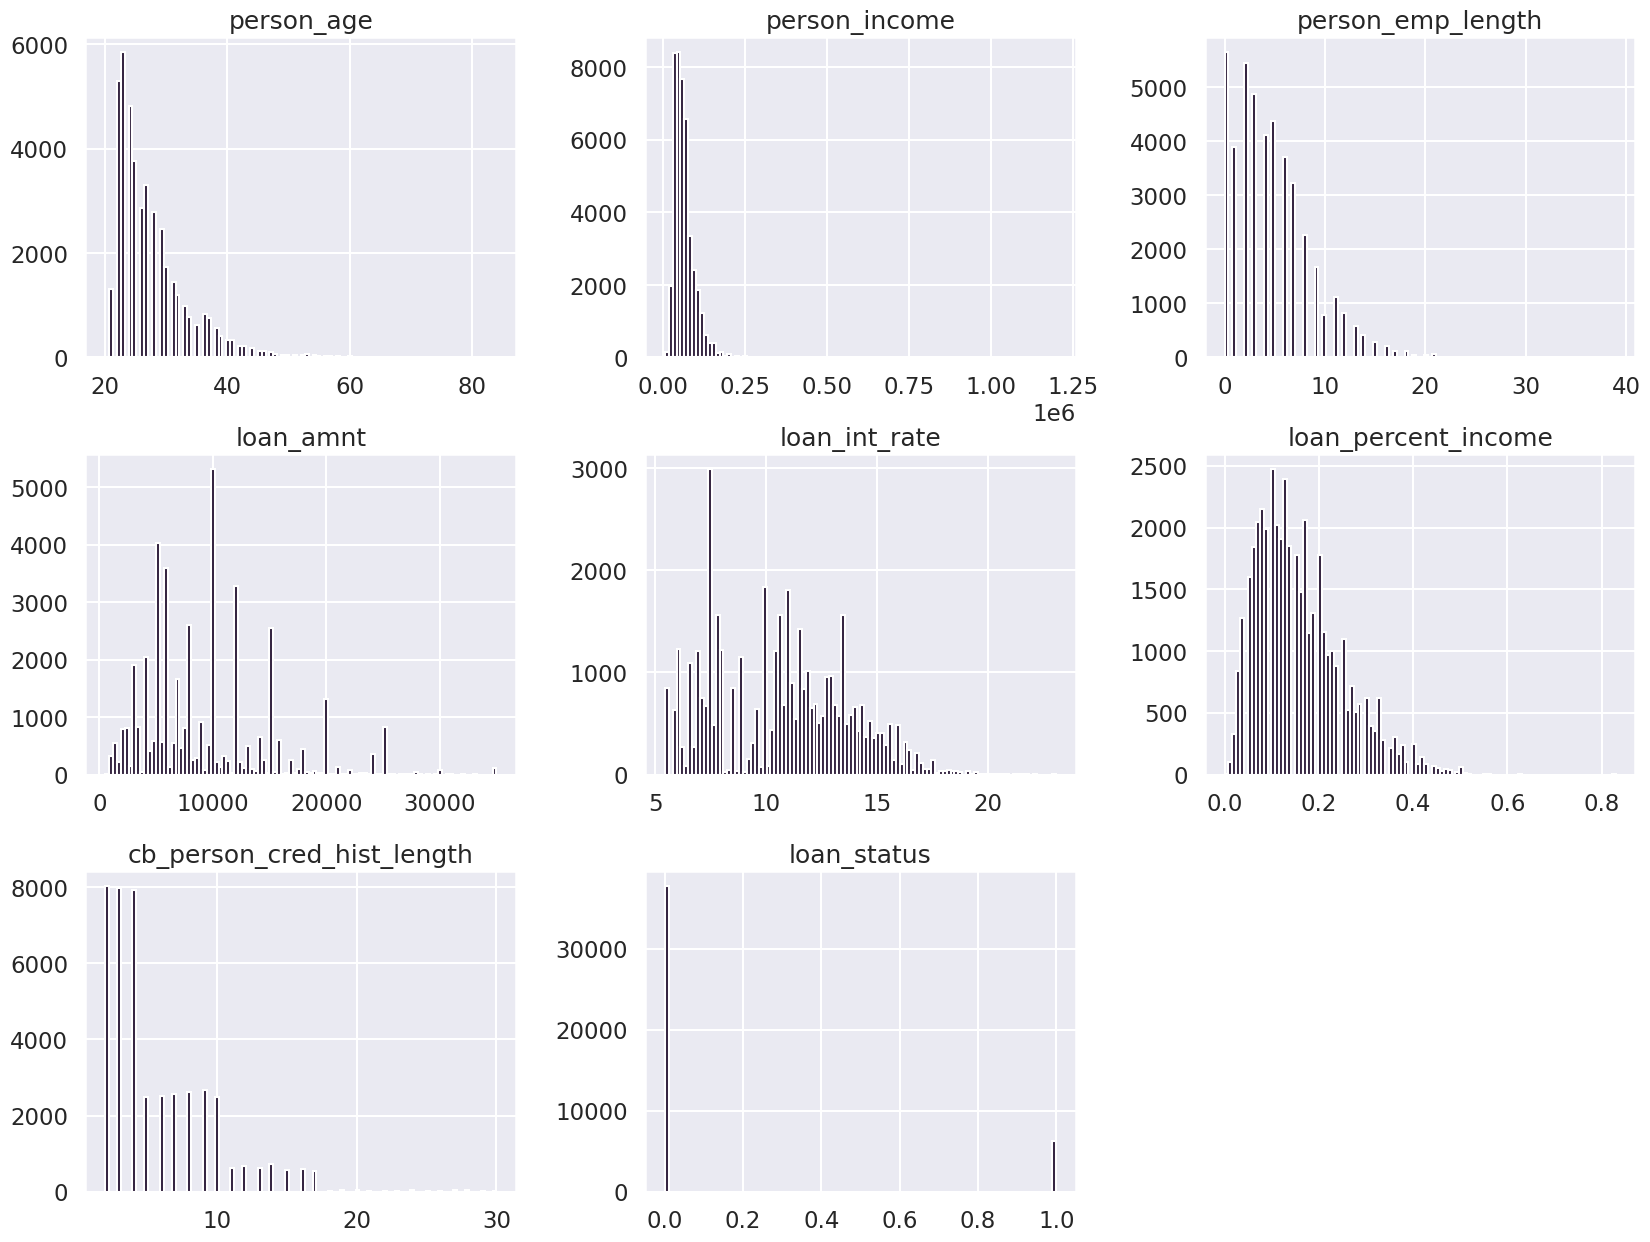

In [10]:
train_df.hist(bins=100, figsize=(20, 15))
plt.show()
# NOTE: a nivell global s'obsrva com person_age, person income, 
# person_emp_lenght, loan_percent_income, estan molt desequiloibrades a la dreta.
# cb_person_cred_hist_lenght
# NOTE: loan_amnt, loan_int_rate NO

#### **Variables categòriques**

In [11]:
# --- Informació bàsica de les variables categòriques ---

display(X_train[cat_features].describe())

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,35186,35186,35186,35186
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,18281,7337,12660,29956


- Veiem que count es el mateix per a totes perquè no hi ha nulls.
- Unique ens diu el nombre de valors possibles de la variable categòrica.
- Top ens diu quina és la categoria més freqüent.
- Freq ens diu la freqüència de la categoria més freqüent.

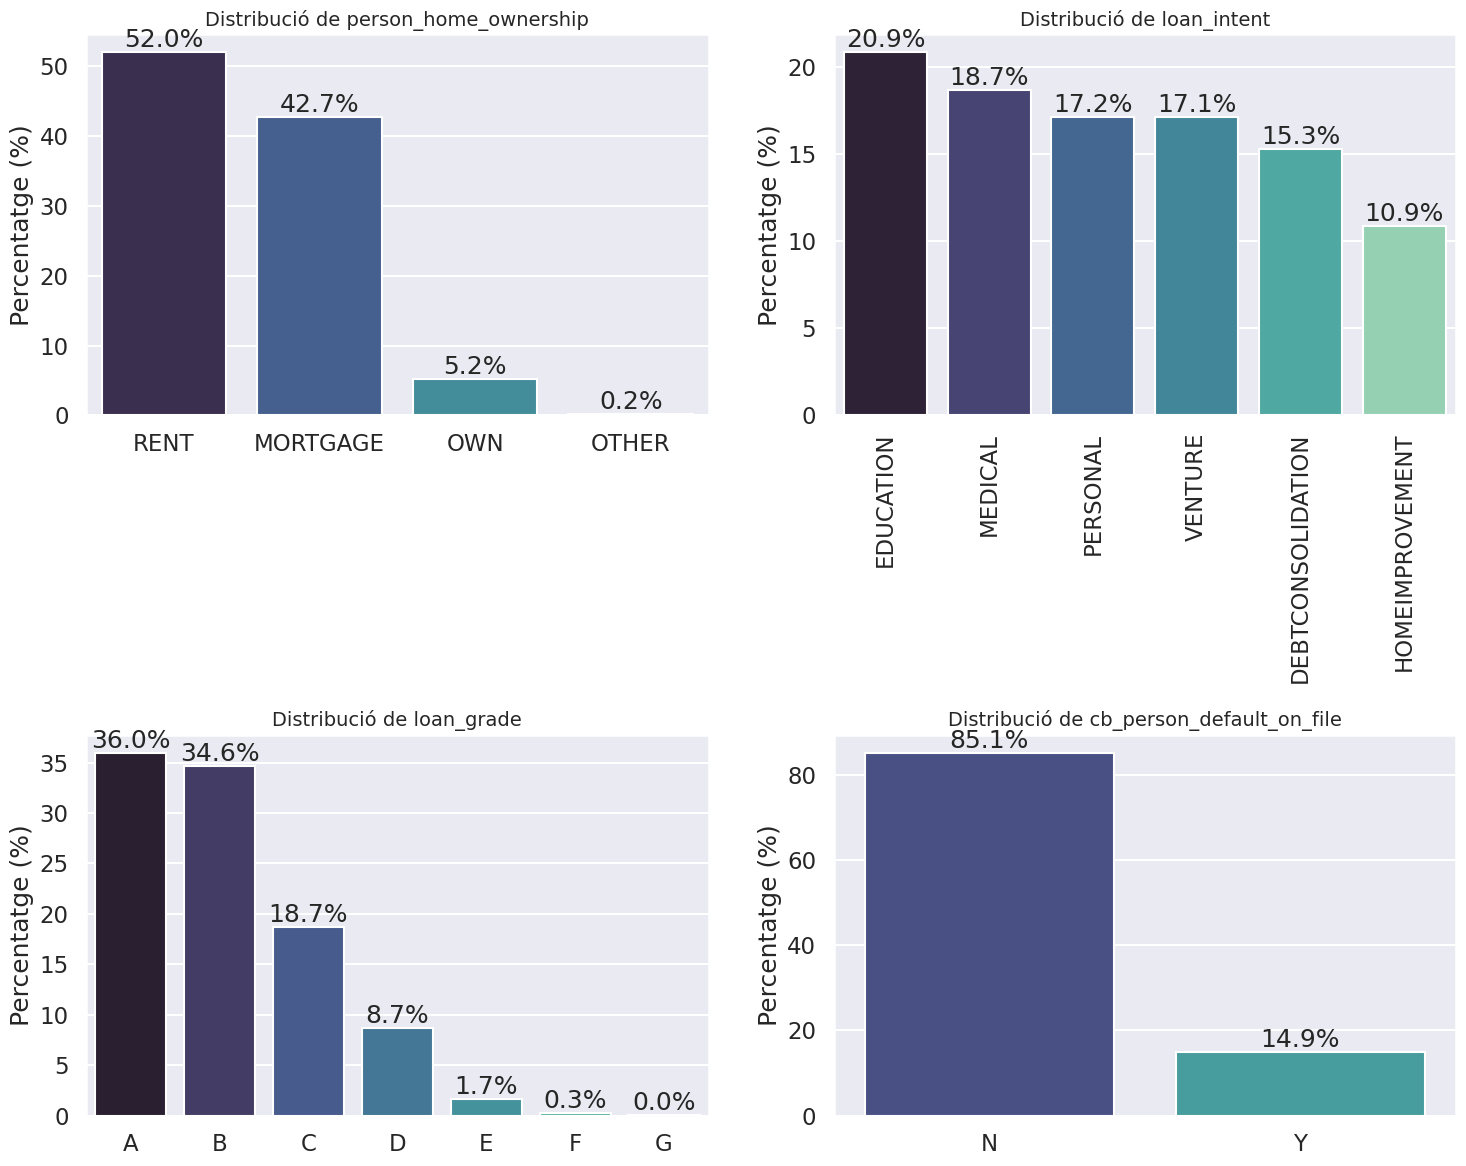

In [12]:
# --- Anàlisi de Dades Categòriques (Distribució i Freqüències) ---

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    ax = axes[i]
    
    # 1. Calculem els percentatges
    data = X_train[col].value_counts(normalize=True).reset_index()
    data.columns = [col, 'percentage']
    data['percentage'] *= 100
    
    # 2. Creem el barplot amb percentatges
    sns.barplot(data=data, x=col, y='percentage', ax=ax, palette="mako")
    
    # 3. Afegim les etiquetes de percentatge a sobre de cada barra
    ax.bar_label(ax.containers[0], fmt='%.1f%%')
    
    ax.set_title(f'Distribució de {col}', fontsize=14)
    ax.set_ylabel('Percentatge (%)')
    ax.set_xlabel('')

    if len(data[col]) > 4 and len(data[col][0]) > 1:
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

- Podem veure com les categories person_home_ownership, loan_grade i cb_person_default estàn molt més desequilibrades que loan_intent.
- Podem veure el percentatge que ocupen les categories més freqüents en cada variable.

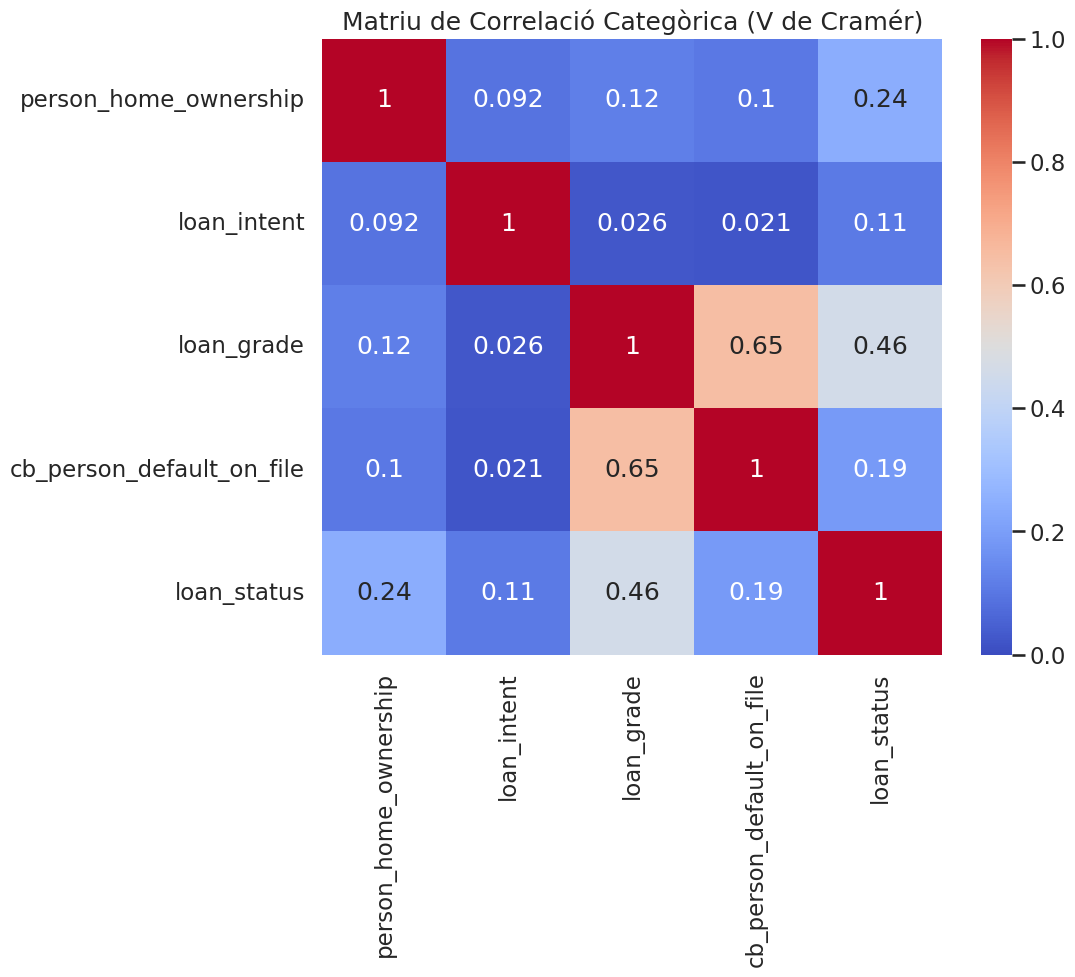

In [13]:
# --- Matriu de Correlació Categòrica (V de Cramér) ---
import scipy.stats as ss

# Funció per calcular la V de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Volem calcular la correlació entre totes les categòriques + l'objectiu
cat_features_with_target = cat_features + ['loan_status']
matrix_df = X_train.join(y_train) # Ja el teníem definit abans

# Creem la matriu buida
corr_matrix = pd.DataFrame(index=cat_features_with_target, columns=cat_features_with_target)

# Calculem la V de Cramér per cada parell
for col1 in cat_features_with_target:
    for col2 in cat_features_with_target:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            corr_matrix.loc[col1, col2] = cramers_v(matrix_df[col1], matrix_df[col2])

corr_matrix = corr_matrix.astype(float)

# Dibuixem el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Matriu de Correlació Categòrica (V de Cramér)")
plt.show()

- Ara hem pogut analitzar la relació que té cada variable categòrica amb la variable objectiu loan_status.
- Podem veure com les variables més corelacionades (que hem pogut capturar) són loan_status i loan_grade i loan_grade amb cb_person_default_on_file.
- Desprès podrem veure si aprofitem aquestes relacions o no en el FeatureEngineer.

### 1.4 Neteja i preparació (preprocesasment)

### 1.5 Transformacions i noves columnes

In [14]:
# --- Exemple de feature engineering (opcional) ---
# TODO: crea noves columnes específiques del teu domini si té sentit
# p.ex., ratios, interaccions, caps de setmana, etc.
# Aquest bloc pot actualitzar X / test_df abans del pipeline.

# --- Funció per crear noves features ---

def create_features(df):
    # Fem una còpia per evitar el SettingWithCopyWarning
    df_new = df.copy()
    
    # Ràtios d'estabilitat/experiència
    # (Sabem per l'EDA que person_age mai és 0, així que no cal afegir epsilon)
    df_new['emp_to_age_ratio'] = df_new['person_emp_length'] / df_new['person_age']
    df_new['cred_hist_to_age_ratio'] = df_new['cb_person_cred_hist_length'] / df_new['person_age']
    
    # Interacció de risc
    df_new['rate_x_percent_income'] = df_new['loan_int_rate'] * df_new['loan_percent_income']
    
    # Omplim possibles NaNs creats per la divisió (tot i que 'person_age' no és 0)
    # o si les columnes originals tenien nuls (abans del SimpleImputer)
    df_new = df_new.fillna(0)
    
    return df_new

# Creem el transformer que aplicarà aquesta funció
feature_engineer = FunctionTransformer(create_features, validate=False)


In [15]:
# --- Definició de les columnes numèriques i categòriques ---
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Afegim els noms de les noves features que crearem
new_num_features = ['emp_to_age_ratio', 'cred_hist_to_age_ratio', 'rate_x_percent_income']
# Important: Creem una nova llista que les inclogui TOTES
all_num_features = num_features + new_num_features

In [16]:
# --- Transformers ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("power_transform", PowerTransformer(method='yeo-johnson')),
    ("scaler", RobustScaler())  
])

# NOTE: ja estem tractant outliers amb RobustScaler, que utilitza la mediana i IQR.
# NOTE: he afegit PowerTransformer per tractar les variables numèriques que eren asimètriques.

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, all_num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Caché del pipeline per accelerar grid_search
cache_dir = mkdtemp()

## 2. Model - Pregunta i mètrica

**Pregunta**: Volem predir la variable objectiu i decidir una política de classificació

**Mètrica d'optimització**: ROC AUC o F1 depenent del cost realtiu de FP vs FN:

* Si les classes estan desequilibrades, prioritzem recall, considera F1 o average precision
* Mantiendrem un panell de mètriques (Accuracy, Precision, Recall, F1, ROC AUC)


### 2.1 Models Candidats

In [17]:
# LinearSVC calibrat per obtenir probabilitats
lin_svm = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("pre", preprocessor),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(
            C=1.0, 
            class_weight="balanced", 
            random_state=42),
            method="sigmoid", 
            cv=StratifiedKFold(
                n_splits=5, 
                shuffle=True, 
                random_state=42
            )
    ))
])

# SVC
rbf_svm = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("pre", preprocessor),
    ("clf", SVC(
            kernel="rbf", 
            C=1.0, 
            gamma="scale", 
            class_weight="balanced", 
            probability=False, 
            random_state=42
    ))
])

### 2.3 Optimització d'hiperparàmetres

In [18]:
# Ajust del shiperparametres
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lin = {
    "clf__estimator__C": [0.1],
    "clf__estimator__tol": [1e-4]
}

# grid_lin = {
#     "clf__estimator__C": [0.1, 0.5, 1.0, 2.0, 5.0],
#     "clf__estimator__tol": [1e-4, 1e-3]
# }

grid_rbf = {
    "clf__C": [2.0],
    "clf__gamma":  [0.035]
}

# grid_rbf = {
#     "clf__C": [0.6, 0.8, 1.0, 1.3, 1.6, 2.0],
#     "clf__gamma":  [0.08, 0.06, 0.05, 0.04, 0.035, 0.03]
# }

g_lin = GridSearchCV(lin_svm, grid_lin, scoring="roc_auc", cv=cv, n_jobs=4, verbose=2, error_score="raise")
g_rbf = GridSearchCV(rbf_svm, grid_rbf, scoring="roc_auc", cv=cv, n_jobs=4, verbose=2, error_score="raise")

print(">> Fitting Linear SVM grid...")
g_lin.fit(X_train, y_train)
best_lin = g_lin.best_estimator_
print("Millor Linear SVM: ", g_lin.best_params_, "CV ROC AUC: ", g_lin.best_score_)

print("\n>> Fitting RBF SVM grid...")
g_rbf.fit(X_train, y_train)
best_rbf = g_rbf.best_estimator_
print("Millor RBF SVM: ", g_rbf.best_params_, "CV ROC: ", g_rbf.best_score_)

>> Fitting Linear SVM grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Millor Linear SVM:  {'clf__estimator__C': 0.1, 'clf__estimator__tol': 0.0001} CV ROC AUC:  0.9026828695111723

>> Fitting RBF SVM grid...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Millor RBF SVM:  {'clf__C': 2.0, 'clf__gamma': 0.035} CV ROC:  0.9217315509233641


### 2.4 Sobreajust

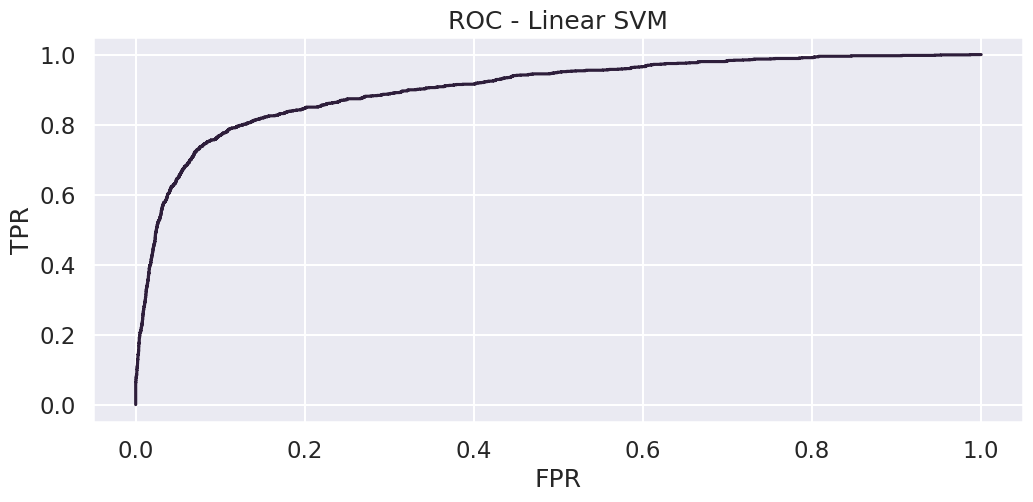

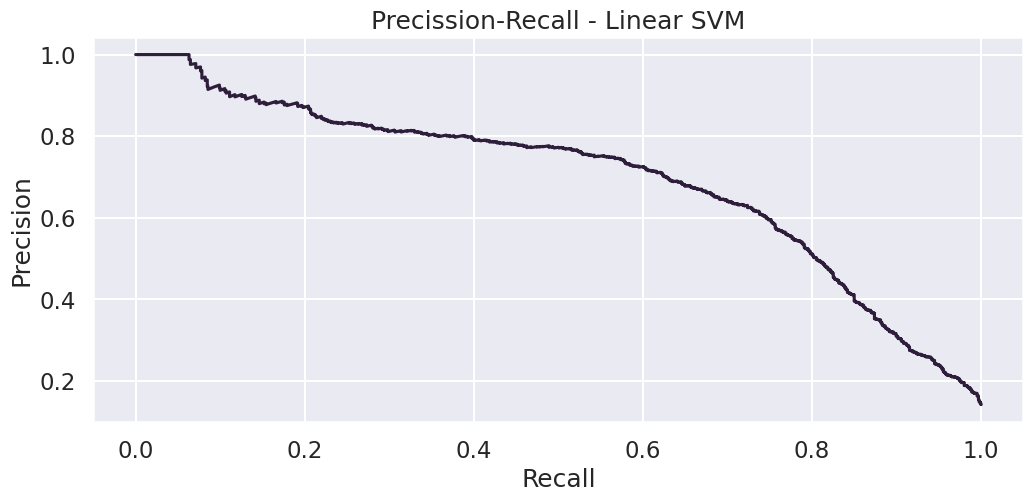

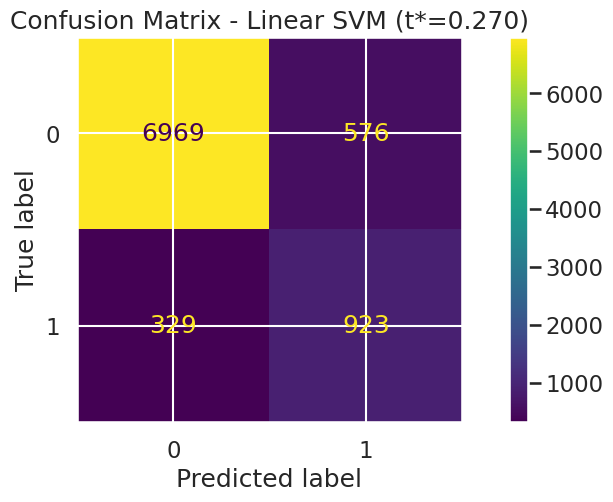

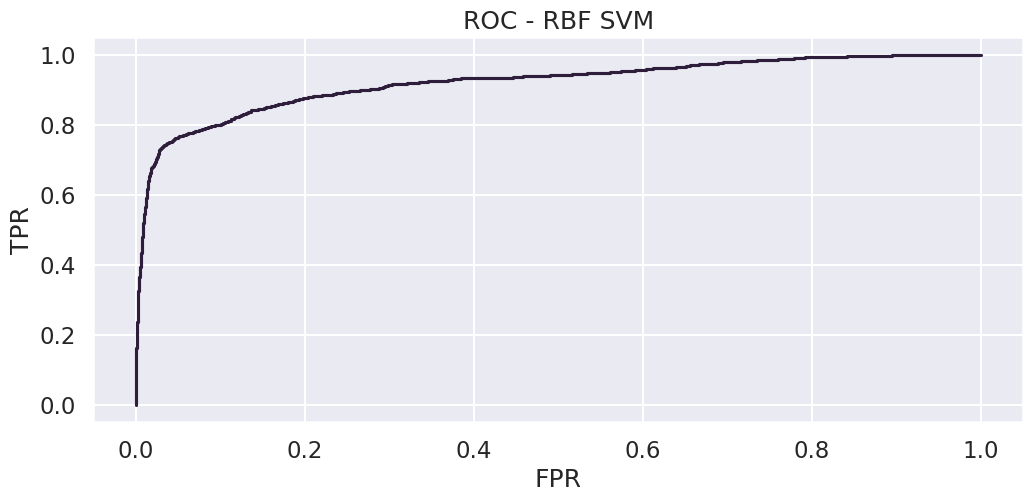

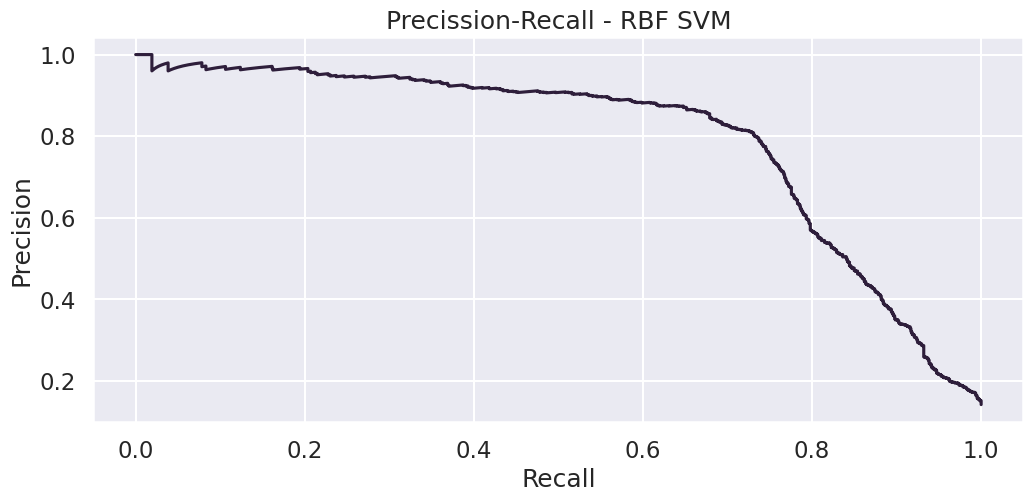

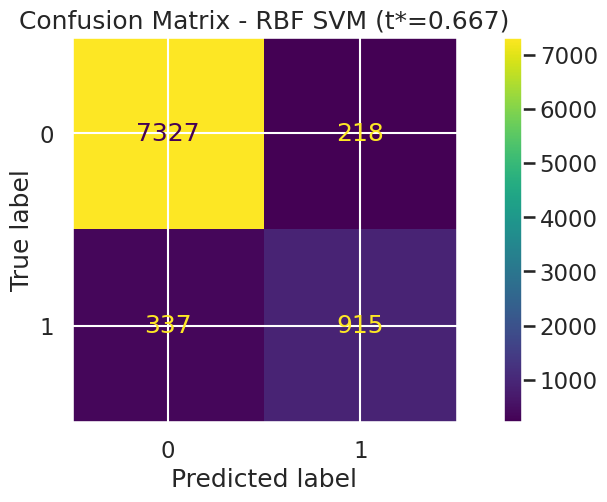

,roc_auc,ap,f1@0.5,f1@t,best_th
name,,,,,
Linear SVM,0.902513,0.695193,0.599313,0.671029,0.270248
RBF SVM,0.919824,0.794422,0.748310,0.767296,0.666649


In [19]:
def eval_with_threshold(model, X_val, y_val, name="model"):
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_val)[:, 1]
    else:
        scores = model.decision_function(X_val)

    # PR i millor llindar per F1
    p, r, ths = precision_recall_curve(y_val, scores)
    eps = 1e-12
    f1s = 2*p*r / (p+2+eps)

    best_idx = int(np.argmax(f1s[1:])) + 1
    best_th = float(ths[best_idx-1])

    preds_05 = (scores >= 0.5).astype(int)
    preds_bt = (scores >= best_th).astype(int)

    res = {
        "name": name,
        "roc_auc": roc_auc_score(y_val, scores),
        "ap": average_precision_score(y_val, scores),
        "f1@0.5": f1_score(y_val, preds_05, zero_division=0),
        "f1@t": f1_score(y_val, preds_bt, zero_division=0),
        "best_th": float(best_th)
    }

    fpr, tpr, _ = roc_curve(y_val, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f"ROC - {name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

    plt.figure()
    plt.plot(r, p)
    plt.title(f"Precission-Recall - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ConfusionMatrixDisplay(confusion_matrix(y_val, preds_bt)).plot()
    plt.title(f"Confusion Matrix - {name} (t*={best_th:.3f})")
    plt.show()

    return res, best_th, scores

res_lin, th_lin, sc_lin = eval_with_threshold(best_lin, X_val, y_val, "Linear SVM")
res_rbf, th_rbf, sc_rbf = eval_with_threshold(best_rbf, X_val, y_val, "RBF SVM")

panel = pd.DataFrame([res_lin, res_rbf]).set_index("name")
display(panel)

### 2.5 Selecció del millor model

Selecciona el model que presenti millor balanç en les mètriques de validació i que **no mostri sobreajust**. En problemes sensibles FN/FP, ajusta el llindar (```threshold```) per aconseguir el punt operatiu desitjat.

In [20]:
# Selecció del millor model
winner = "RBF, SVM" if panel.loc["RBF SVM", "roc_auc"] >= panel.loc["Linear SVM", "roc_auc"] else "Linear SVM"
best_model = best_rbf if winner=="RBF SVM" else best_lin
best_th = th_rbf if winner=="RBF SVM" else th_lin
print(f"Model guanyador: {winner} | llindar vàlid òptim: {best_th:.4f}")

X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_full, y_full)

Model guanyador: RBF, SVM | llindar vàlid òptim: 0.2702


Pipeline(steps=[('feature_engineer',
                 FunctionTransformer(func=<function create_features at 0x7f9fed325e40>)),
                ('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('clf',
                 CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                        estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            random_state=42)))])

### 3. Avaluació, final, test i presentació

In [21]:
# Prediccions al test
if 'id' in test_df.columns:
    test_ids = test_df['id'].values
    X_test = test_df.drop(columns=['id'])
else:
    # id está en el índice
    test_ids = test_df.index.values
    X_test = test_df.copy()

# 2) Saca las probabilidades/scores del modelo ganador
if hasattr(best_model, "predict_proba"):
    test_scores = best_model.predict_proba(X_test)[:, 1]
else:
    df = best_model.decision_function(X_test).reshape(-1, 1)
    test_scores = MinMaxScaler().fit_transform(df).ravel()  # <-- ¡ahora sí asignamos test_scores!

# 3) Carga SIEMPRE el sample_submission oficial y respeta su orden de 'id'
SAMPLE_PATH = "/kaggle/input/ml-ub-2025-project-2/sample_submission.csv"  # ajusta a tu comp
sub = pd.read_csv(SAMPLE_PATH)

# 4) Alinea por id (mismo orden que sample). No reordena test_df, reindexa los scores.
scores_by_id = pd.Series(test_scores, index=test_ids, name=sub.columns[-1])  # suele ser 'loan_status'
sub[sub.columns[-1]] = scores_by_id.reindex(sub['id']).values

# 5) Validaciones útiles (fallarán si hay desalineación)
assert sub['id'].is_unique and len(sub) == len(test_ids), "Tamaños/ids no casan"
assert not np.isnan(sub[sub.columns[-1]].values).any(), "Hay NaNs en la predicción alineada"

# 6) Guarda submission
OUT_PATH = "/kaggle/working/submission.csv"
sub.to_csv(OUT_PATH, index=False)
print("Submission creada:", OUT_PATH)
print(sub.head())

Submission creada: /kaggle/working/submission.csv
      id  loan_status
0  43983     0.125540
1  43984     0.003392
2  43985     0.871940
3  43986     0.000458
4  43987     0.054584
